# Assignment 4

### 1. Import Libraries

In [1]:
import numpy as np
from keras.datasets import cifar10
import cv2
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


### Load Data

In [2]:
(xtrain,ytrain),(xtest,ytest)=cifar10.load_data()
xtrain, xvalidation, ytrain, yvalidation = train_test_split(xtrain, ytrain, test_size=0.2, random_state=42)

## Feature 1: RGB Color Histogram

In [24]:
## Feature 1 (RGB Color Histograms)
histogramsTrain=[]
for i, img in enumerate(xtrain):
    hist0 = cv2.calcHist([xtrain[i]],[0],None,[256],[0,256])
    hist1 = cv2.calcHist([xtrain[i]],[1],None,[256],[0,256])
    hist2 = cv2.calcHist([xtrain[i]],[2],None,[256],[0,256])
    hist=np.concatenate((hist0, hist1,hist2), axis=1)
    histogramsTrain.append(hist)
histogramsVal=[]
for i, img in enumerate(xtest):
    hist0 = cv2.calcHist([xtest[i]],[0],None,[256],[0,256])
    hist1 = cv2.calcHist([xtest[i]],[1],None,[256],[0,256])
    hist2 = cv2.calcHist([xtest[i]],[2],None,[256],[0,256])
    hist=np.concatenate((hist0, hist1,hist2), axis=1)
    histogramsVal.append(hist)

## Feature 2: HOG Descriptors

In [7]:
## Feature 2 (HOG Descriptors)
winSize = (32,32)
blockSize = (8,8)
blockStride = (4,4)
cellSize = (4,4)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
hogTrain=[]
for i, img in enumerate(xtrain):
    gray = cv2.cvtColor(xtrain[i], cv2.COLOR_BGR2GRAY)
    hist = hog.compute(gray)
    hogTrain.append(hist)

hogVal=[]
for i, img in enumerate(xtest):
    gray = cv2.cvtColor(xtrain[i], cv2.COLOR_BGR2GRAY)
    hist = hog.compute(gray)
    hogVal.append(hist)

## Feature 3: Deep Learning Model Feature Representation 

In [12]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import scipy
from scipy import misc
import keras

### Definition of the model: Reusing a pretrained network

In [13]:
model = InceptionV3(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

### Feature Extraction (Training, validation)

In [14]:
x_trainResized=[]
for i in range(0, len(xtrain)):
    x_trainResized.append(scipy.misc.imresize(xtrain[i], (96, 96, 3)))
x_trainResized = np.array(x_trainResized).astype('float32')
x_valResized=[]
for i in range(0, len(xvalidation)):
    x_valResized.append(scipy.misc.imresize(xvalidation[i], (96, 96, 3)))
x_valResized = np.array(x_valResized).astype('float32')
x_train_preproced = preprocess_input(x_trainResized)
x_validation_preproced = preprocess_input(x_valResized)

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  import sys


In [15]:
#Training Features Deep Learning Model
featuresTraining = model.predict(x_train_preproced)
featuresTraining = np.squeeze(featuresTraining)


In [41]:
#Validation Features Deep Learning Model
featuresValidation = model.predict(x_validation_preproced)
featuresValidation = np.squeeze(featuresValidation)

## Features Evaluation and Selection

In [95]:
from scipy.spatial.distance import euclidean
#Best Feature Selection
##HOG Distance
def evaluateFeature(method):
    if method==0:
        print("Color Histograms")
        FEATURE_TRAINING=histogramsTrain
        FEATURE_VAL=histogramsVal
    elif method==1:
        print("HOG - HISTOGRAMS OF GRADIENTS")
        FEATURE_TRAINING=hogTrain
        FEATURE_VAL=hogVal
    else:
        print("Deep Neural Network")
        FEATURE_TRAINING=featuresTraining
        FEATURE_VAL=featuresValidation
    N_predictions=10
    fScores=[]
    for i in range(len(xvalidation[:100])):
        #i=0
        
        x2=FEATURE_VAL[i]
        target=yvalidation[i][0]
        #print(target)
        distances={}
        totalClass=0
        for j in range(len(FEATURE_TRAINING)):
            x1=FEATURE_TRAINING[j]
            dis=np.linalg.norm(x1-x2)
            distances[j]=dis
            if(target==ytrain[j]):
                totalClass+=1
        #print(totalClass)

        sorted_distances = sorted(distances.items(), key=lambda kv: kv[1])
        sorted_distances=sorted_distances[:N_predictions]
        meanTheshold=np.array(list(dict(sorted_distances).values())).mean()
        truePositives=0
        total2=0
        for index,distance in sorted_distances:
            predictedLabel=ytrain[index]
            if(predictedLabel==target):
                truePositives+=1
            if (distance<meanTheshold):
                total2+=1
            #print(predictedLabel)
        precision=truePositives/N_predictions
        recall=N_predictions/N_predictions
        f1Score=2*(precision*recall)/(precision+recall)
        fScores.append(f1Score)
    #print(precision)
    #print(recall)
    print("F1-Score: "+str(np.array(fScores).mean()))
print("Evaluation::")
evaluateFeature(0)
print("-------------")
print("Evaluation::")
evaluateFeature(1)
print("-------------")
print("Evaluation::")
evaluateFeature(2)

Evaluation::
Color Histograms
F1-Score: 0.18758280934751528
-------------
Evaluation::
HOG - HISTOGRAMS OF GRADIENTS
F1-Score: 0.11350863189098483
-------------
Evaluation::
Deep Neural Network
F1-Score: 0.5688122747565472


# Content Bases Information Retrieval

### Test set preprocesing

In [101]:
## Preprocess Test Images
x_testResized=[]
for i in range(0, len(xtest)):
    x_testResized.append(scipy.misc.imresize(xtest[i], (96, 96, 3)))
x_testResized = np.array(x_testResized).astype('float32')
x_test_preproced = preprocess_input(x_testResized)
featuresTest = model.predict(x_test_preproced)

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.


## System Demo

Test Image Selected: 8928


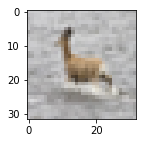

Top-4 Simmilar Images


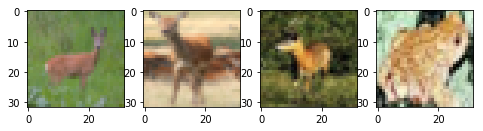

Bottom-4 Simmilar Images


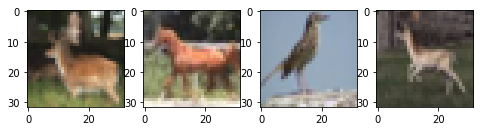

In [136]:
import random
import matplotlib.pyplot as plt
x=[]
N_predictions=10
while len(x)<1:
    plt.figure(figsize=(2,2))
    num=random.randint(0,len(xtest))
    #print(num)
    x.append(num)
    print("Test Image Selected: "+str(num))
    
    img=xtest[num]
    plt.imshow(img)  # graph it
    plt.show()
    x2=featuresTest[num]
    distances={}
    for j in range(len(featuresTraining)):
        x1=featuresTraining[j]
        dis=np.linalg.norm(x1-x2)
        distances[j]=dis        
    #print(totalClass)
    fig = plt.figure(figsize=(8,8))
    sorted_distances = sorted(distances.items(), key=lambda kv: kv[1])
    sorted_distances=sorted_distances[:N_predictions]
    imagesIndex=dict(sorted_distances).keys()
    #print(list(imagesIndex)[:4])
    k=1
    print("Top-4 Simmilar Images")
    for i in range(len(list(imagesIndex)[:4])):
        ax1 = fig.add_subplot(1,4,k)
        ax1.imshow(xtrain[list(imagesIndex)[:4][i]])
        k+=1
    plt.show()
    fig = plt.figure(figsize=(8,8))
    k=1
    
    for i in range(len(list(imagesIndex)[-4:])):
        ax1 = fig.add_subplot(1,4,k)
        ax1.imshow(xtrain[list(imagesIndex)[-4:][i]])
        k+=1
    print("Bottom-4 Simmilar Images")